## **Feature selection by a cross-validation using random forest classifier**

In [1]:
from util import *
import pickle
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import sklearn.naive_bayes as nb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.inspection import permutation_importance

In [2]:
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option("display.max_rows", 999)
pd.set_option("display.max_columns", None)
pd.set_option("precision", 3)
sns.set_context("talk") # talk context is good for RISE presentations
%pylab inline
%config InlineBackend.figure_formats = ['retina']

Populating the interactive namespace from numpy and matplotlib


### **1. Load clean data set**

In [3]:
q = """
SELECT * from ma_refinance_new
"""
df = do(q)
df.head(3)

,derived_msa_md,county_code,conforming_loan_limit,derived_loan_product_type,derived_race,derived_sex,lien_status,open_end_line_of_credit,business_or_commercial_purpose,hoepa_status,interest_only_payment,balloon_payment,occupancy_type,total_units,applicant_race_1,applicant_sex,applicant_age_above_62,co_applicant_age_above_62,loan_term,loan_amount,property_value,loan_to_value_ratio,income,debt_to_income_ratio,total_age,applicant_age,co_applicant_age,action_taken,denial_reason_1,denial_reason_2,denial_reason_3,denial_reason_4
0,15764,25017,C,First,White,Male,1,2,2,2,2,2,1,1,White,1,No,N/A,180,"265,000.00",815000,32.10,114.00,33,40,40,0,1,10,nan,nan,nan
1,15764,25009,C,First,Race Not Available,Male,1,2,1,3,2,2,3,2,No info.,1,No,N/A,300,"265,000.00",525000,50.29,89.00,25,30,30,0,1,10,nan,nan,nan
2,15764,25017,C,First,White,Male,1,2,2,2,2,2,1,1,White,1,No,N/A,360,"305,000.00",575000,52.27,75.00,45,40,40,0,1,10,nan,nan,nan


#### **1.1 Separate categorical and continuous variables to facilitate OneHotEncoding incross validation**

In [4]:
x_cat = gen_cat(df)
x_cont = gen_cont(df)
y = df[['action_taken']]

### **2. Run randomized search cross-validation**
 Randomized search cv gives similar results to that from grid search cv, but it leads to drastically low computation cost.  
 Refs:
 [sklearn doc](https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html)
 [Hyperparameter Tuning the Random Forest in Python](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74)

### **2.1. Split the data**
 Split the data into training and testing datasets (70% vs. 30%). Also, split testing dataset into validation and testing datasets (30% vs 70%). The validation dataset is used to generate permutation feature importances

In [5]:
categorical_columns = list(x_cat.columns)
numerical_columns = list(x_cont.columns)
x = df[categorical_columns + numerical_columns]
#-------------------------------------------------------------------------
testing_portion = 0.3
x_train, x_test, y_train, y_test = train_test_split(
    x, y, stratify=y, random_state=15, test_size=testing_portion)
#-------------------------------------------------------------------------
validation_portion = 0.3
x_test, x_val, y_test, y_val = train_test_split(
    x_test, y_test, stratify=y_test, random_state=15, test_size=validation_portion)

data_dict = make_data_dict(x_train, y_train,
                           x_test, y_test,
                           x_val, y_val,
                           )
fn = '../data/data_vf.pickle'
save_as_pickle(fn, data_dict)

Saved data to "../data/data_vf.pickle"


### **2.2 Run randomized search cross-validation using random forest classifier**

In [6]:
random_grid = gen_hypergrid_for_rf_cv()
base_mdl = RandomForestClassifier()
rf_random = make_cv_pipelinie(base_mdl,
                              categorical_columns,
                              numerical_columns,
                              random_grid,
                              scoring='roc_auc'
                             )
rf_random.fit(x_train, y_train)

# save the pipeline model
fn = '../data/rf_pipeline.pickle'
save_as_pickle(fn, rf_random)

{'classifier__n_estimators': [100, 200, 300, 400, 500], 'classifier__max_features': ['auto', 'sqrt', 'log2'], 'classifier__max_depth': [10, 20, 30, 40, 50, None], 'classifier__min_samples_split': [2, 5, 10, 15, 20], 'classifier__min_samples_leaf': [1, 2, 4], 'classifier__bootstrap': [True, False]}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  8.3min finished


Saved data to "../data/rf_pipeline.pickle"


### **3. Get permutation importance using the validation dataset generated in section 2.1**
- Impurity-based feature importance can inflate the importance of numerical features.
- The impurity-based feature importance of random forests suffers from being computed on statistics derived from the training dataset: the importances can be high even for features that are not predictive of the target variable, as long as the model has the capacity to use them to overfit.

Ref: [Permutation Importance vs Random Forest Feature Importance (MDI)](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py)


In [7]:
fn = '../data/rf_pipeline.pickle'
rf_random = read_from_pickle(fn)
result = permutation_importance(rf_random.best_estimator_, x_val, y_val, n_repeats=10,
                                random_state=15, n_jobs=-1)

Read data from "../data/rf_pipeline.pickle"


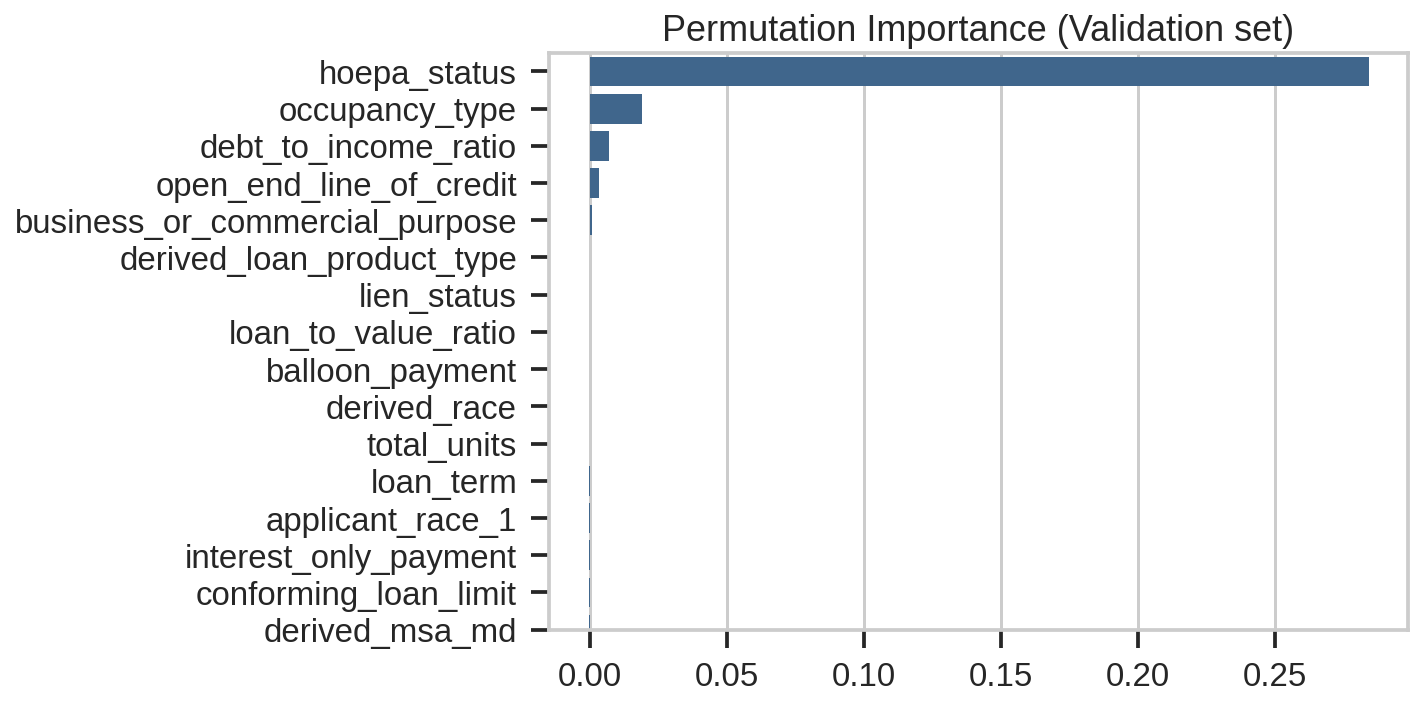

In [8]:
sorted_idx = result.importances_mean.argsort()[::-1]
mean_importance = result.importances_mean[sorted_idx]
fig, ax = plt.subplots(figsize=(10, 5))

ax = sns.barplot(x=mean_importance,
                 y=x_test.columns[sorted_idx],
                color=[0.2, 0.4, 0.6])
ax.set_ylim([15, -0.5])
ax.set_title("Permutation Importance (Validation set)")
fig.tight_layout()

plt.savefig("../figures/feat_sel_permut_importance.svg",
            dpi=300, bbox_inches='tight', facecolor="white")

In [9]:
thresh = np.percentile(mean_importance, 75)
idx_sel_feat_sorted = mean_importance > thresh
idx_sel_feat = sorted_idx[idx_sel_feat_sorted]
fn = '../data/idx_sel_feat_permu_importance.pickle'
save_as_pickle(fn, idx_sel_feat)

Saved data to "../data/idx_sel_feat_permu_importance.pickle"
